# Item2Vec

We learn good semantic representations for items (products) from transactional data using word2vec. Orders are interpreted as sentences and product as words.

Dataset: Instacart
* Data: https://www.kaggle.com/c/instacart-market-basket-analysis#prizes
* Description: https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b
* Backup (data and description): https://drive.google.com/drive/folders/1JC-D3vtYI6iOSGaZ9DoSXDQ4GrvMzqLL?usp=sharing

Installation: Download and unzip internal archives into the collocated 'data' folder. See the structure and list of CSV files in the Data Loading section.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 8


## Data Loading and Exploration

In [2]:
DATA_PATH = 'data/instacart-market-basket-analysis'
files_list = glob.glob(f'{DATA_PATH}/*.csv')

files_list

['data/instacart-market-basket-analysis/products.csv',
 'data/instacart-market-basket-analysis/orders.csv',
 'data/instacart-market-basket-analysis/order_products__train.csv',
 'data/instacart-market-basket-analysis/departments.csv',
 'data/instacart-market-basket-analysis/aisles.csv',
 'data/instacart-market-basket-analysis/order_products__prior.csv']

In [ ]:
data_dict = {}

for file in files_list:
    print(f'\n\nReading: {file}')
    data = pd.read_csv(file)
    print(data.info(null_counts=True))

    print(f'\nSample ({file}):')
    display(HTML(data.sample(min(10, len(data))).to_html()))
    print(f'\nDataset stats ({file}):')
    display(HTML(data.describe().T.to_html()))
    
    print(f'\nColumn stats ({file}):')
    for col in data.columns:
        print(f'\nColumn {col} has {data[col].nunique()} unique values')
        print(f"Example of values: {data[col].unique()[:10]}")

    data_dict[file.split('.')[0].split('/')[-1]] = data
    
data_dict.keys()

## Data Preparation

In [4]:
order_product_cnt_ds = data_dict['order_products__prior'].groupby('order_id').count()[['product_id']]
order_product_cnt_ds.columns = ['product_cnt']
order_ds = data_dict['orders'].merge(order_product_cnt_ds, left_on='order_id', right_index=True)      # add product counters to orders

order_ds.info()
order_ds.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3421081
Data columns (total 8 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
product_cnt               int64
dtypes: float64(1), int64(6), object(1)
memory usage: 220.7+ MB


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_cnt
668401,1616362,40271,prior,3,0,15,13.0,11
1386952,2832255,83361,prior,4,0,12,9.0,3
861426,443334,51760,prior,25,5,9,3.0,7
1892363,3000723,113604,prior,9,6,19,8.0,4
2820207,781774,170158,prior,22,0,10,7.0,19


## Data Summary

In [5]:
# Helper function to printing large numbers 
def to_readable(v):
    value = round(v,2) if isinstance(v, float) else v
    if value < 1000:
        return str(value)
    elif value < 1000000:
        return str(round(value/1000,1)) + 'K'
    elif value >= 1000000:
        return str(round(value/1000000,1)) + 'M'
    return value

total_user = len(order_ds.user_id.unique())
total_order = len(order_ds)
total_ordered_product = len(data_dict['order_products__prior'])
unique_products = len(data_dict['order_products__prior'].product_id.unique())

print("total user = {}".format(to_readable(total_user)))
print("total order = {} ({} orders per user)".format(to_readable(total_order), to_readable(total_order/total_user) ))
print("total product = ", to_readable(unique_products))
print("total ordered product  = {} ({} orders per product)".format(to_readable(total_ordered_product), to_readable(total_ordered_product/unique_products) ))

total user = 206.2K
total order = 3.2M (15.59 orders per user)
total product =  49.7K
total ordered product  = 32.4M (652.91 orders per product)


We now proceed to learning a good semantic representation for items (products) using word2vec model.

## Item2Vec, Step 1: Prepare a Product Corpus

In [6]:
merge_order_product_ds = data_dict['order_products__prior'].merge(order_ds, on='order_id' )

print('Creating sequences based on transactions...')
order_product_list = merge_order_product_ds\
    .sort_values(['user_id','order_id','add_to_cart_order'])[['order_id','product_id']]\
    .values.tolist()

# Each entry of a corpus is one order represented by a chronologically sorted sequence of product IDs.
print('Preparing a corpus of items...')
product_corpus = []     
sentence = []
new_order_id = order_product_list[0][0]
for (order_id, product_id) in tqdm(order_product_list):
    if new_order_id != order_id:
        product_corpus.append(sentence)
        sentence = []
        new_order_id = order_id
    sentence.append(str(product_id))

Creating sequences based on transactions
Preparing a corpus of items


## Item2Vec, Step 2: Train Word2Vec model

We use implementation from Gensim adjusting the following parameters:
* sentences = product_corpus
* window - maximum distance between the current and predicted word within a sentence.
* size - dimensionality of the word vectors.
* min_count - ignores all words with total frequency lower than this.

In [9]:
TRAIN_ITEM_MODEL = True   # True - create a new model, False - load a previosuly created model
LOGGING_ELABLED = False
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [32]:
from gensim.models import Word2Vec

if LOGGING_ELABLED:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
    
WORD_DIM = 200
model_filename = f'models/item2vec.{WORD_DIM}d.model'
if TRAIN_ITEM_MODEL:
    model = Word2Vec(product_corpus, 
                window=5, 
                size=WORD_DIM, 
                workers=mp.cpu_count() - 2, 
                min_count=100)
    
    model.save(model_filename)
    print(f'Model saved to [{model_filename}]')
    
else:
    model = Word2Vec.load(model_filename)
    print(f'Model loaded from [{model_filename}]')

Model saved to [models/item2vec.200d.model]


In [23]:
def to_product_name(id, columns='product_name'):
    return data_dict['products'][data_dict['products'].product_id==id][columns].values.tolist()[0]

def most_similar_readable(model, product_id, topn=10):
    similar_list = [(product_id, 1.0)] + model.wv.most_similar(str(product_id), topn=topn)
    return pd.DataFrame([( to_product_name(int(id)), int(id), similarity ) for (id, similarity) in similar_list],
                        columns=['product', 'product_id', 'similarity'])

In [24]:
# Reality check: Show the nearest neighbors for several common products 
for product_id in [13176, 39180, 2326]:
    most_similar_readable(model, product_id) 

,product,product_id,similarity
0,Bag of Organic Bananas,13176,1.000000
1,Organic Banana,37067,0.789016
2,Banana,24852,0.734720
3,Organic D'Anjou Pears,22825,0.572784
4,Organic Kiwi,39928,0.538047
5,Organic Granny Smith Apple,39877,0.537134
6,Organic Bosc Pear,46969,0.526742
7,Organic Raspberries,27966,0.526250
8,Organic Large Extra Fancy Fuji Apple,19057,0.520874
9,Organic Navel Orange,8174,0.512837


,product,product_id,similarity
0,Organic Lowfat 1% Milk,39180,1.000000
1,Organic Reduced Fat Milk,38689,0.954821
2,Organic Multigrain Waffles,9825,0.749109
3,Organic Homestyle Waffles,25753,0.741653
4,1% Lowfat Milk,24024,0.737987
5,Organic Blueberry Waffles,2326,0.731962
6,Organic Mini Homestyle Waffles,162,0.725061
7,Organic Yokids Lemonade/Blueberry Variety Pack Yogurt Squeezers Tubes,10761,0.719363
8,Low Fat Vanilla Yogurt,30442,0.710136
9,Organic Whole String Cheese,22035,0.708991


,product,product_id,similarity
0,Organic Blueberry Waffles,2326,1.000000
1,Organic Homestyle Waffles,25753,0.893069
2,Organic Multigrain Waffles,9825,0.891449
3,Organic Mini Homestyle Waffles,162,0.842979
4,Apple Cinnamon Instant Oatmeal,37464,0.808800
5,Original Veggie Straws,34448,0.792176
6,Four Cheese Thin Crust Pizza,5959,0.784738
7,Organic Cinnamon Apple Sauce,15995,0.777008
8,Ice Cream Sandwiches Vanilla,38274,0.773188
9,Florida Orange Juice With Calcium & Vitamin D,8087,0.767886


## Item2Vec, Step 3: Visualize the Semantic Space Using TSNE

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances

In [26]:
# prepare the embeddings for TSNE
word_vectors = model.wv
vocab = list(model.wv.vocab.keys())
item2vector_dict = {arg:model.wv[arg] for arg in vocab}
X = pd.DataFrame(item2vector_dict).T.values
X.shape, len(vocab), vocab[0]

((20067, 100), 20067, '196')

In [27]:
# perform TSNE
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=-1)
tsne = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results = tsne.fit_transform(distance_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20067 samples in 0.222s...
[t-SNE] Computed neighbors for 20067 samples in 11.006s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20067
[t-SNE] Computed conditional probabilities for sample 2000 / 20067
[t-SNE] Computed conditional probabilities for sample 3000 / 20067
[t-SNE] Computed conditional probabilities for sample 4000 / 20067
[t-SNE] Computed conditional probabilities for sample 5000 / 20067
[t-SNE] Computed conditional probabilities for sample 6000 / 20067
[t-SNE] Computed conditional probabilities for sample 7000 / 20067
[t-SNE] Computed conditional probabilities for sample 8000 / 20067
[t-SNE] Computed conditional probabilities for sample 9000 / 20067
[t-SNE] Computed conditional probabilities for sample 10000 / 20067
[t-SNE] Computed conditional probabilities for sample 11000 / 20067
[t-SNE] Computed conditional probabilities for sample 12000 / 20067
[t-SNE] Computed conditional probabilities for sa

In [33]:
df_semantic_item = pd.DataFrame({'product_id': vocab})
df_semantic_item['tsne-2d-one'] = tsne_results[:,0]
df_semantic_item['tsne-2d-two'] = tsne_results[:,1]
df_semantic_item['product_id'] = df_semantic_item['product_id'].astype(int)

df_semantic_item = df_semantic_item.merge(data_dict['products'], on='product_id', how='left')
df_semantic_item = df_semantic_item.merge(data_dict['aisles'], on='aisle_id', how='left')
df_semantic_item = df_semantic_item.merge(data_dict['departments'], on='department_id', how='left')

df_semantic_item.sample(5)

,product_id,tsne-2d-one,tsne-2d-two,product_name,aisle_id,department_id,aisle,department
9062,44609,6.508562,-9.440644,Chocolate Graham Snacks,61,19,cookies cakes,snacks
14103,35173,22.292690,-10.177940,Organic Wild Blend Rice,3,19,energy granola bars,snacks
3926,33651,7.346388,-10.698230,Harvest Cheddar Multigrain Chips,107,19,chips pretzels,snacks
7678,18877,21.772549,-19.946905,Clean Breeze® High Efficiency Liquid Laundry Detergent,75,17,laundry,household
19016,17472,5.178184,-27.980083,Juicy Green Apple Shampoo,22,11,hair care,personal care


In [34]:
n_aisle = df_semantic_item['aisle'].nunique()
n_department = df_semantic_item['department'].nunique()
print(f"Unique aisles: {n_aisle}") 
print(f"Unique departments: {n_department}")

Unique aisles: 134
Unique departments: 21


<Figure size 1152x1152 with 0 Axes>

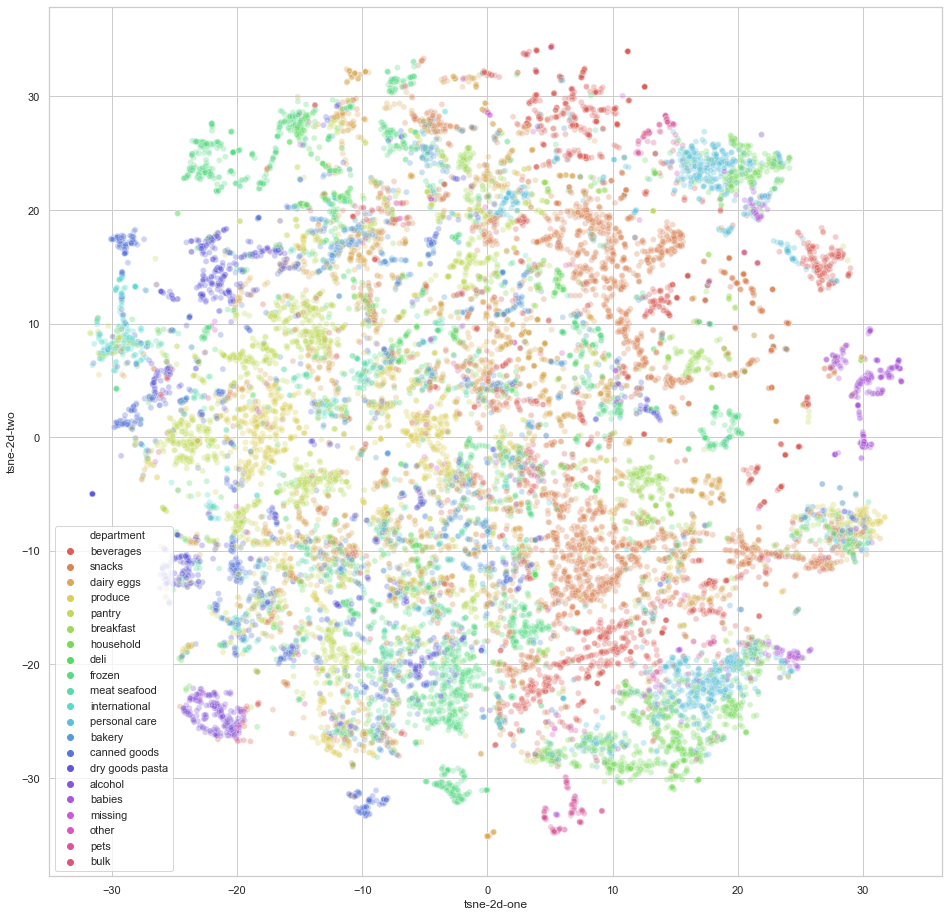

In [35]:
# visualize the entire semantic space and its mapping to the departments
plt.figure(figsize=(16, 16))
sns.set_style("whitegrid")
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='department',
    palette=sns.color_palette("hls", n_department),
    data=df_semantic_item,
    legend="full",
    alpha=0.3
)
plt.show()

Products in the selected aisles: 2706


<Figure size 1440x576 with 0 Axes>

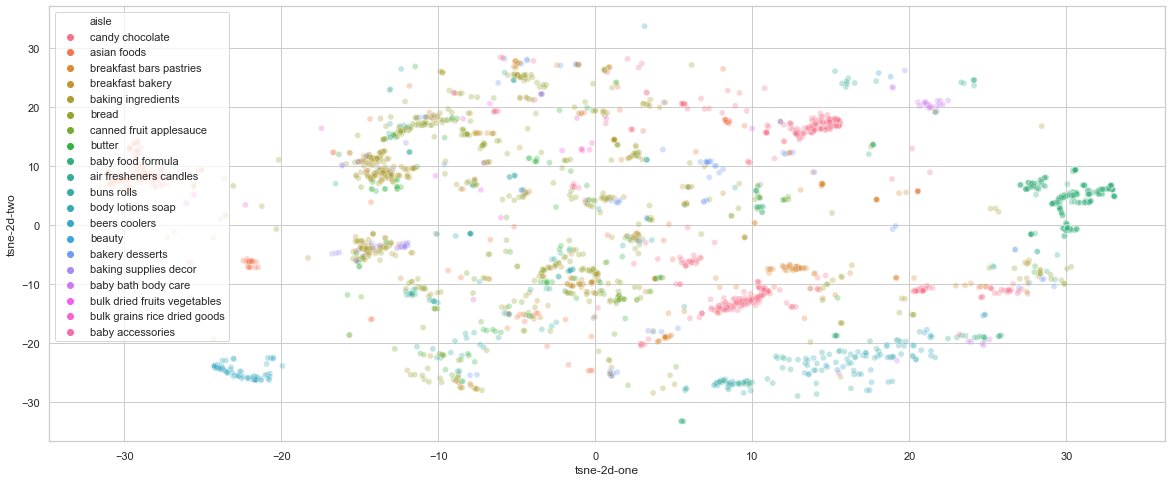

In [36]:
# visualize the mapping between the semantic space and aisles
aisle_list = sorted(df_semantic_item['aisle'].unique())
aisle_set = aisle_list[:20]   # take a subset of aisles to keep it readable

print(f'Products in the selected aisles: {df_semantic_item[df_semantic_item.aisle.isin(aisle_set)].shape[0]}')
plt.figure(figsize=(20, 8))
sns.scatterplot(
   x="tsne-2d-one", y="tsne-2d-two",
   hue='aisle',
   data=df_semantic_item[df_semantic_item.aisle.isin(aisle_set)],
   legend="full",
   alpha=0.3
)
plt.show()

Conslusion: The semantic space has a meaningful internal structure aligned with the typical product taxonomy (departments and aisles).

## Item2Vec, Step 4: Compare the Original Semantic Space and Its t-SNE Projection

In this section, we compare the original (200 dimensional) semantic space with its t-SNE projection.

In [40]:
from sklearn.metrics import silhouette_samples, silhouette_score

for space_name, space in {'TSNE': tsne_results, 'raw latent space': model.wv.vectors}.items():
    for entity in ['department', 'aisle']:
        silhouette_avg = silhouette_score(space, df_semantic_item[entity], metric="cosine")
        print(f"The number of unique {entity}s is {df_semantic_item[entity].nunique()} " +\
              f"and the average silhouette_score on {space_name} is : {silhouette_avg:.4}")

The number of unique departments is 21 and the average silhouette_score on TSNE is : -0.5551
The number of unique aisles is 134 and the average silhouette_score on TSNE is : -0.7932
The number of unique departments is 21 and the average silhouette_score on raw latent space is : -0.05171
The number of unique aisles is 134 and the average silhouette_score on raw latent space is : -0.117


Conclusion: Although well-defined semantically meanighful clusters exist in the t-SNE projection, the original space is less structured. This can be confirmed by replacing t-SNE by SVD - the resulting projection is not structured well.

<Figure size 576x576 with 0 Axes>

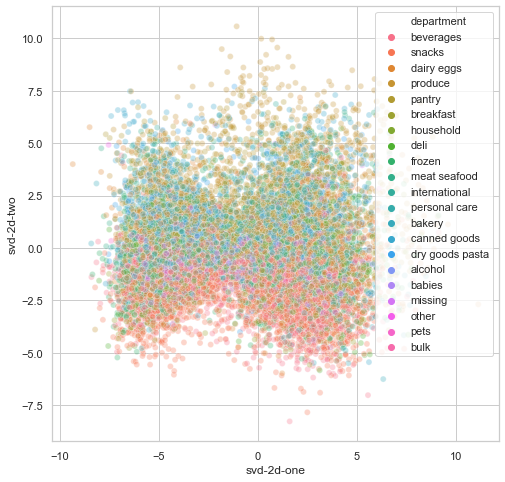

In [41]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

df_svd = pd.DataFrame({'product_id': vocab})
df_svd['svd-2d-one'] = X_reduced[:,0]
df_svd['svd-2d-two'] = X_reduced[:,1]
df_svd['product_id'] = df_svd['product_id'].astype(int)

df_svd = df_svd.merge(data_dict['products'], on='product_id', how='left')
df_svd = df_svd.merge(data_dict['aisles'], on='aisle_id', how='left')
df_svd = df_svd.merge(data_dict['departments'], on='department_id', how='left')

plt.figure(figsize=(8, 8))
sns.scatterplot(
        x="svd-2d-one", y="svd-2d-two",
        hue='department',
        data=df_svd,
        legend="full",
        alpha=0.3
    )
plt.show()